In [1]:
from IPython.core.display import display, HTML, Markdown
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import numpy as np
import random
import numpy.random as rd
import matplotlib.pyplot as plt

import import_ipynb
import sys
#import boris_stepper
from Functions import push_particles

import pandas as pd
from pandas import Series, DataFrame
from scipy.optimize import curve_fit 

%matplotlib inline
%matplotlib notebook

importing Jupyter notebook from Functions.ipynb


In [3]:
path_in = 'C:\\Users\\mathe\\OneDrive\\Área de Trabalho\\Monte Carlo\\23102023\\Simulação eventos\\'

* ### Constantes

In [4]:
c      = 299792458  # velocidade da luz em m/s
dt     = 1e-2       # passo temporal em segundos.
Nsteps = 8500       # número de passos temporais. 2000
skip   = 2          # Taxa de pulos no dados salvos.

t=np.zeros(int(Nsteps/skip)+1)
t[0] = 0.0  

# Definição dos parâmetros relevantes para o inicio da simulação.

# Carga da partícula. +1 para próton, e -1 para elétron
q =  1.0
qe = 1.60217662e-19 # carga elementar.

# Massa da partícula em função da massa do elétron
m = 1.836e3
me= 9.10938356e-31 # massa do elétron em kg.

# rest mass energy in eV
# magnetic permeability of vacuum.
muo=4*np.pi*1e-7

# Razão dos calores específicos ratio of specific heats
gamma= 2

# Parâmetros físicos pré-choques obtidos no evento do dia 01/12/2-15
B = 6.27     # nT
n = 7.94     # cm^-3
T = 8.78*1e5 # K

n1  = n*1e6                                             # particle number density in #/m^3
T1  = T/11604 # em eV                                   # ion temperature in eV. Electron temperature assumed to be the same.
B1  = B*1e-9                                            # magnetic field strength in Tesla.

B1u = np.array([0,0,B1])
v1  = 503*1e3      # km/s  4.95e5                       # drifting speed in m/s

# derived parameters
Eu = -np.cross(np.array([0,v1,0]),B1u)                  # electric field. The same on both sides.
p1 = 2*n1*1.3806e-23*(T1*1.1604e4)                      # thermal pressure in Pa (the "2" comes from p = pi + pe = n1*k_B*(Ti+Te)=2*n1*k_B*T1).
rho1 = n1*(m*me)                                        # particle mass density in kg/m^3.
R1 = np.sqrt(p1/rho1)*(m*me)/((np.abs(q)*1.602e-19)*B1) # thermal gyroradius in m.

## Carregamento dos dados 

In [5]:
vxi = np.loadtxt(path_in+'Vx_MB.txt'); v_d = np.loadtxt(path_in+'Vy_MB.txt'); vzi = np.loadtxt(path_in+'Vz_MB.txt'); n = np.loadtxt(path_in+'n.txt')

# Simulação boris 2 D

In [10]:
# ------------------------------------------------------
# Loop over the "npart" particles.
# ------------------------------------------------------
# Boundaries of the simulation box in the X-direction. 

x0lower = -5.0
x0upper = 5.0 

# Geração das posições em x
x = x0lower+rd.random(len(v_d))*(x0upper-x0lower)

rx = np.zeros([int(Nsteps/skip)+1,len(v_d)]); ry = np.zeros([int(Nsteps/skip)+1,len(v_d)]); rz = np.zeros([int(Nsteps/skip)+1,len(v_d)])
vx = np.zeros([int(Nsteps/skip)+1,len(v_d)]); vy = np.zeros([int(Nsteps/skip)+1,len(v_d)]); vz = np.zeros([int(Nsteps/skip)+1,len(v_d)])
ek = np.zeros([int(Nsteps/skip)+1,len(v_d)]); mu = np.zeros([int(Nsteps/skip)+1,len(v_d)]); rL = np.zeros([int(Nsteps/skip)+1,len(v_d)])

for i in range(len(v_d)):
    
    x0 = x[i]*R1
    y0 = -4.0*R1 
    z0 = 0.0
    
    r0  = np.array([x0, y0, z0])
    r   = r0
    
    vx0 = vxi[i]
    vy0 = v_d[i]
    v   = np.array([vx0,vy0,0])

    v1std = np.linalg.norm(v)
    
    em = 0.5*(rho1*(v1std**2)+B1**2/(muo))+p1
    
    zeta = ( (2*gamma*em-rho1*(v1std**2))+ np.sqrt((2*gamma*em-rho1*(v1std**2))**2 - 4*rho1*(gamma+1)*(gamma-2)*(v1std*B1)**2/muo ) )/(2*rho1*(gamma+1)*v1std**2)  
    
    # Lorentz's factor
    gammaL = 1.0/np.sqrt(1.0-(v[0]**2+v[1]**2+v[2]**2)/c**2)
    
    # particle velocity with factor gamma
    u = np.array([gammaL*v[0], gammaL*v[1], gammaL*v[2]])
    rx[0,i]=r0[0];  ry[0,i]=r0[1];  rz[0,i]=r0[2]
    vx[0,i]=v[0];   vy[0,i]=v[1];   vz[0,i]=v[2]
    ek[0,i]=gammaL-1 
    mu[0,i]=(gammaL-1)/(np.linalg.norm(B1u))
    rL[0,i]=(m*me)*np.linalg.norm(v1std)/(np.abs(q*qe)*(np.linalg.norm(B1u)))
    
    counter=0
    efield = Eu         
    for it in range(Nsteps):
        if r[1] < 0.:
            bfield = B1u
        else:
            bfield = B1u/zeta
            
            v[0]=v[0]*zeta
            v[1]=v[1]*zeta
            v[2]=v[2]*zeta                                           
                                      
        r,v = push_particles(qe,m*me,dt,c,efield,bfield,u,r,v)
        #r,v = boris_stepper.push_particles(q,m,dt,c,efield,bfield,u,r,v)
        
        # apply periodic boundary conditions along x-direction for the special case of a symmetric interval. 
        # left boundary condition
        if r[0] < x0lower*R1: r[0] = r[0] + (np.abs(x0upper)+np.abs(x0lower))*R1
        # right boundary condition
        if r[0] > x0upper*R1: r[0] = r[0] - (np.abs(x0upper)+np.abs(x0lower))*R1
        
        if np.mod(it,skip) == 0:
            
            rx[counter+1,i]=r[0]; ry[counter+1,i]=r[1]; rz[counter+1,i]=r[2] 
            vx[counter+1,i]=v[0]; vy[counter+1,i]=v[1]; vz[counter+1,i]=v[2]
            gammaL=1.0/np.sqrt(1.0-(v[0]**2+v[1]**2+v[2]**2)/c**2)
            ek[counter+1,i]= gammaL-1
            mu[counter+1,i]=(gammaL-1)/np.linalg.norm(bfield)
            
            #vperp = np.sqrt(v[0]**2+v[1]**2+v[2]**2-np.square(np.dot(v,bfield)/np.linalg.norm(bfield)))
            vperp = np.sqrt(v[0]**2+v[1]**2+v[2]**2-(np.dot(v,bfield)/np.linalg.norm(bfield))**2)
            
            rL[counter+1,i]=(m*me)*vperp/(np.abs(q*qe)*(np.linalg.norm(bfield))) # Larmor radius
            t[counter+1]=t[counter]+dt*skip
            counter=counter+1

## Salvamento (primeira iteração)

In [18]:
#C:\Users\mathe\OneDrive\Área de Trabalho\Monte Carlo\23102023\Simulação eventos\2D

np.savetxt(path_in+'2D\\'+'rx.txt', rx); np.savetxt(path_in+'2D\\'+'ry.txt', ry)  
np.savetxt(path_in+'2D\\'+'vx.txt', vx); np.savetxt(path_in+'2D\\'+'vy.txt', vy) 
np.savetxt(path_in+'2D\\'+'ek.txt', ek); np.savetxt(path_in+'2D\\'+'mu.txt', mu) ; np.savetxt(path_in+'2D\\'+'rL.txt', rL)

##  Carregamento

In [6]:
rx = np.loadtxt(path_in+'2D\\'+'rx.txt'); ry = np.loadtxt(path_in+'2D\\'+'ry.txt') 
vx = np.loadtxt(path_in+'2D\\'+'vx.txt'); vy = np.loadtxt(path_in+'2D\\'+'vy.txt') 
#ek = np.loadtxt(path_in+'2D\\'+'ek.txt'); mu = np.loadtxt(path_in+'2D\\'+'mu.txt') ; rL = np.loadtxt(path_in+'2D\\'+'mu.txt')

## Gráficos 

In [7]:
y_p = 4.540730333267608

<IPython.core.display.Javascript object>


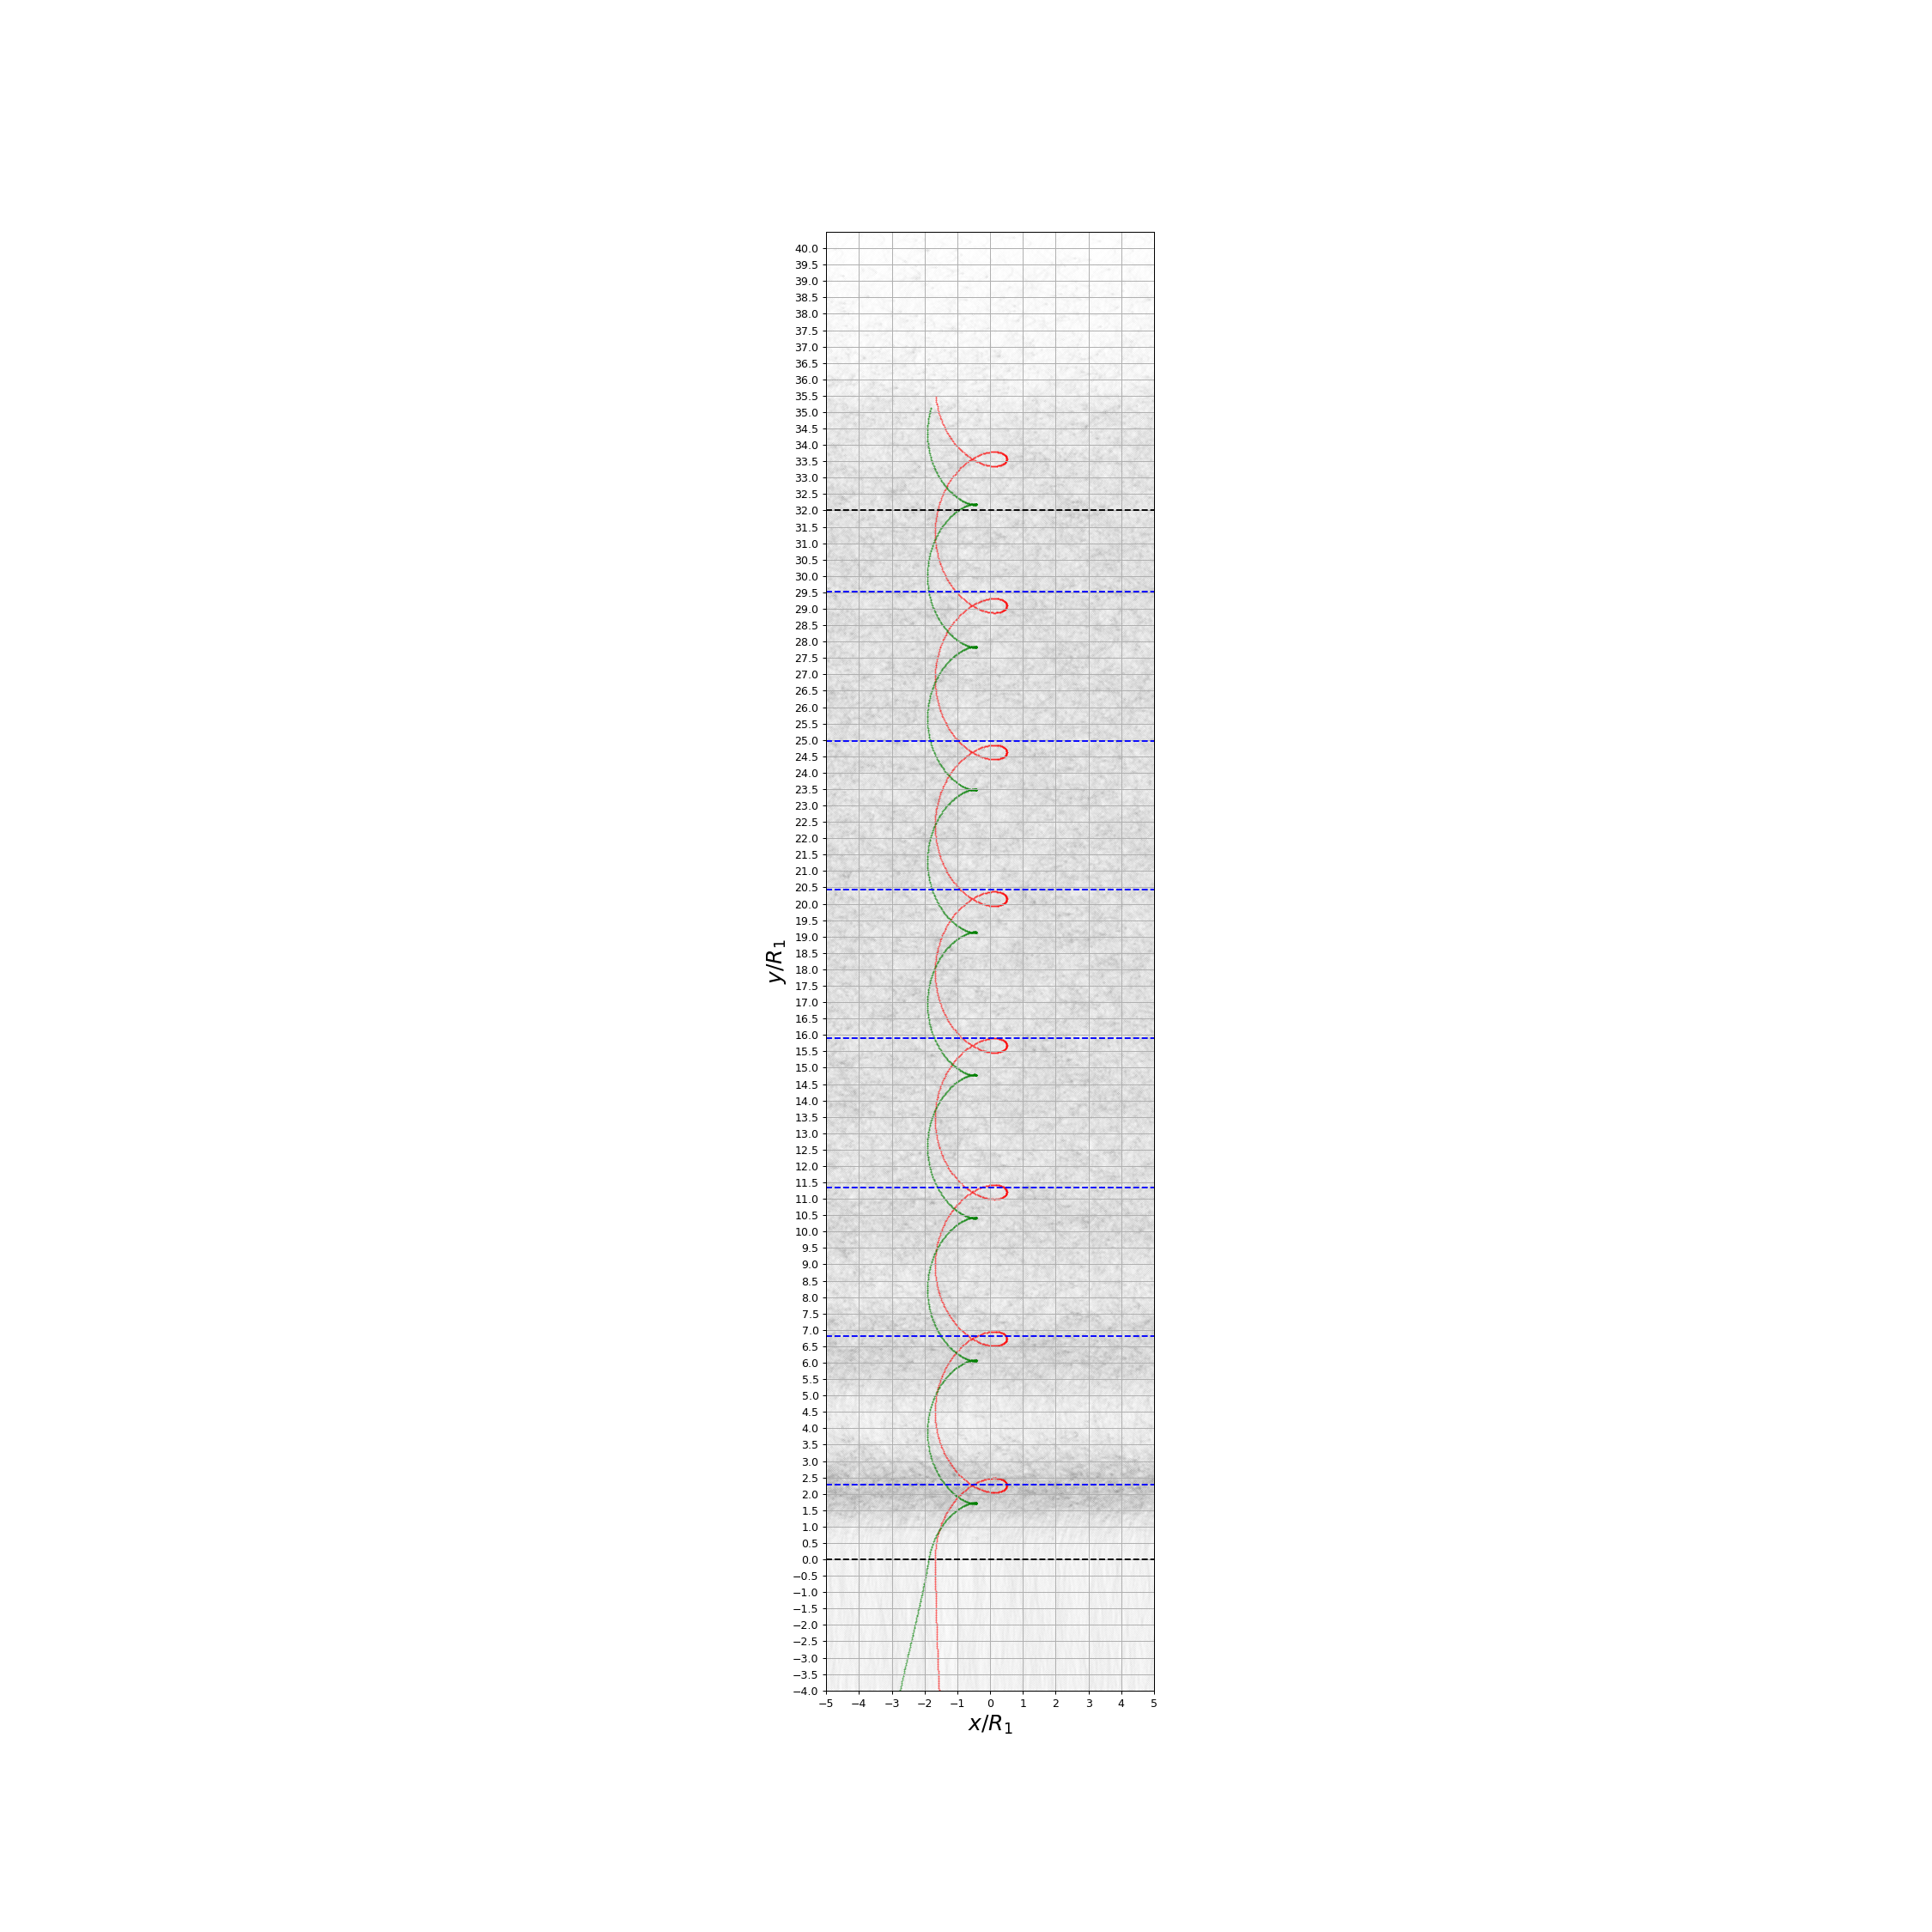

In [8]:
ynlim = 1800
y0 = -4.0*R1 

fig,ax = plt.subplots(1,1,figsize=(20,20))

ax.scatter(rx[:ynlim,0:50000:20]/R1,ry[:ynlim,0:50000:20]/R1,s=0.00001, color='k')

ax.scatter(rx[:ynlim,10]/R1  , ry[:ynlim,10]/R1,s=0.5,marker='.', color='r')
ax.scatter(rx[:ynlim,1200]/R1, ry[:ynlim,1200]/R1,s=0.5,marker='.', color='g')

#ax.plot(x0/R1,y0/R1,'sk',markersize=12,markerfacecolor='none', markeredgecolor='black')

for i in range(0,7):
    
    ax.axhline(y= (1/2+i)*y_p, color='blue', linestyle='--')
    

ax.axhline(y=0.0, color='k', linestyle='--')
ax.axhline(y=32., color='k', linestyle='--')

ax.set_ylim([-4,40.5]);  #[y0/R1,100.5]
ax.set_xlim([-5,5])

ax.set_xticks(np.arange(-5,5.1,1))

ax.set_yticks(np.arange(-4,40.1,0.5))

ax.set_xlabel(r'$x/R_1$',size=20);ax.set_ylabel(r'$y/R_1$',size= 20)
ax.grid(axis='both')

ax.set_aspect(1)

#plt.savefig(path_in+'2D\\plot_01.png',dpi=300, bbox_inches='tight',facecolor='w', edgecolor='w')

## Discretização 

In [9]:
rx.shape

(4251, 50000)

In [10]:
# Ajuste do tamanho dos vetores posição (rx e ry) para realizar a descritização dentro de uma faixa especifica.
rx_d = rx[:ynlim,:]; ry_d = ry[:ynlim,:]

rx_d.shape, ry_d.shape

((1800, 50000), (1800, 50000))

In [69]:
# Definição dos parâmetros de simulação
dx = 0.10
dy = 0.10

# Limites em x e y x0lower = -5.0 x0upper = 5.0   
x_1 = -5 ;  y_1 = -4
x_2 =  5 ;  y_2 = 32
 
# Definição das regiões pré-choque e pós-choque
i_up = int((0-y_1)/dy)          #Construção dos indices para os vetores
i_dw = int((y_2-y_1)/dy)

# Discretização 
x_i = int((x_2-x_1)/dx)
y_i = int((y_2-y_1)/dy)

rx_d = rx_d/R1; ry_d = ry_d/R1
    
#Cálculo das densidades numéricas    
cc   = np.zeros((x_i, y_i))
c_vx = np.zeros((x_i, y_i))
c_vy = np.zeros((x_i, y_i))

x_size = np.arange(len(rx_d))
y_size = np.arange(len(rx_d[0,:]))

x_ii = np.arange(x_1, x_2, dx)
y_jj = np.arange(y_1, y_2, dy)

for i in x_size:
    
    for j in y_size:
        
        for k in x_ii:
            
            if k <rx_d[i,j]< k + dx:
                
                for l in y_jj:
                    
                    if l < ry_d[i,j] < l+dy:
                        
                        cc[round((k-x_1)/dx),   round((l-y_1)/dy)]  += 1
                        c_vx[round((k-x_1)/dx), round((l-y_1)/dx)]  += vx[i,j]
                        c_vy[round((k-x_1)/dy), round((l-y_1)/dy)]  += vy[i,j]
                        
                        break
                break
                
cm_vx = c_vx/cc; cm_vy = c_vy/cc  # Valores médios
cc_n = cc/np.max(cc)  
    
#Cálculo dos pesos    
cm_v = np.sqrt(cm_vx**2+cm_vy**2)

w_i = (n1*v1)/((cc*cm_v)/(dx*R1*dy*R1))  
    
# Densidade     
Z_d = w_i.T*cc.T/(dx*R1*dy*R1)
    
aa = np.mean(Z_d[:][0:i_up])/1e6       # Valor médio da densidade na região pré-choque
bb = np.mean(Z_d[:][i_up:i_dw])/1e6    # Valor médio da densidade na região pós-choque 
    
#Fluxo em X    
F_X = (w_i.T*cc.T/(dx*R1*dy*R1))*cm_vx.T  
    
#Fluxo em Y   
F_Y = (w_i.T*cc.T/(dx*R1*dy*R1))*cm_vy.T 

### Salvamento 

In [70]:
#path_in+'boris2D\\Extensao\\ ; path_in+'boris2D\\'+'cc_01.txt'
#path_in+'boris2D\\Extensao_100

np.savetxt(path_in+'2D\\'+'cc_01_32.txt', cc); 
np.savetxt(path_in+'2D\\'+'w_i_01_32.txt', w_i) 
np.savetxt(path_in+'2D\\'+'cvx_01_32.txt', cm_vx)
np.savetxt(path_in+'2D\\'+'cvy_01_32.txt', cm_vy)

### Carregamento 

In [11]:
cc    = np.loadtxt(path_in+'2D\\'+'cc_01_32.txt')
w_i   = np.loadtxt(path_in+'2D\\'+'w_i_01_32.txt') 
cm_vx = np.loadtxt(path_in+'2D\\'+'cvx_01_32.txt')
cm_vy = np.loadtxt(path_in+'2D\\'+'cvy_01_32.txt')

# Definição dos parâmetros de simulação
dx = 0.10
dy = 0.10

# Limites em x e y x0lower = -5.0 x0upper = 5.0 
x_1 = -5 ;  y_1 = -4
x_2 =  5 ;  y_2 = 32     
 
# Definição das regiões pré-choque e pós-choque
i_up = int((0-y_1)/dy)          #Construção dos indices para os vetores
i_dw = int((y_2-y_1)/dy)

#Cálculo dos pesos    
cm_v = np.sqrt(cm_vx**2+cm_vy**2)
cc_n = cc/np.max(cc) 
    
# Densidade     
Z_d = w_i.T*cc.T/(dx*R1*dy*R1)
    
aa = np.mean(Z_d[:][0:i_up+1])/1e6       # Valor médio da densidade na região pré-choque
bb = np.mean(Z_d[:][i_up+1:i_dw])/1e6    # Valor médio da densidade na região pós-choque 
    
#Fluxo em X    
F_X = (w_i.T*cc.T/(dx*R1*dy*R1))*cm_vx.T  
    
#Fluxo em Y   
F_Y = (w_i.T*cc.T/(dx*R1*dy*R1))*cm_vy.T 

# Contas

In [49]:
f11 = np.mean(F_X[:][0:i_up])/1e11
f12 = np.mean(F_X[:][i_up:])/1e11 

f21 = np.mean(F_Y[:][0:i_up])/1e11
f22 = np.mean(F_Y[:][i_up:])/1e11 

F_1 = np.sqrt(f11**2+f21**2)
F_2 = np.sqrt(f12**2+f22**2)

n_1 = (aa*1e6)
n_2 = (bb*1e6)

v_1 = (F_1*1e11)/n_1 
v_2 = (F_2*1e11)/n_2

np.shape(F_X[:][0:i_up]), np.shape(F_X[:][i_up:i_dw]), f11, f12, f21, f22, v_1, v_2, aa, bb/aa

((40, 100),
 (320, 100),
 -0.5822945891243921,
 0.23674484893891398,
 39.931615289800426,
 39.83595369153724,
 490706.5269510037,
 210315.58144997794,
 8.138440894187433,
 2.3273956881190916)

In [13]:
Fx = pd.DataFrame(F_X,  columns=np.arange(x_1+dx/2,x_2,dx) , index = np.arange(y_1+dy/2,y_2,dy))
Fy = pd.DataFrame(F_Y,  columns=np.arange(x_1+dx/2,x_2,dx) , index = np.arange(y_1+dy/2,y_2,dy))

Fx = Fx.T/1e11
Fy = Fy.T/1e11

Fx

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,31.05,31.15,31.25,31.35,31.45,31.55,31.65,31.75,31.85,31.95
-4.95,0.566992,0.312880,-0.021351,0.014955,-0.154996,0.091205,-0.025028,0.092438,0.042233,0.150484,...,-1.303856,0.620981,-1.247304,1.076812,1.115472,1.672540,-0.073037,2.709483,1.807552,4.387745
-4.85,0.079740,-0.145616,-0.109692,0.004345,-0.140740,-0.153881,-0.031395,0.021154,-0.132132,-0.584233,...,-0.089499,0.406230,-2.672047,1.559271,0.249690,2.369831,1.887302,1.775604,5.204959,4.621986
-4.75,0.140601,0.501290,0.451461,0.316911,0.299903,0.176584,-0.239656,-0.312322,-0.412845,-0.449649,...,1.331412,0.205045,-0.961387,1.443468,0.333984,2.056622,0.886861,3.223138,3.353363,5.158239
-4.65,0.169686,0.151970,0.280627,0.031856,-0.450529,-0.315130,-0.309029,0.064615,0.123696,-0.003650,...,-1.291197,2.001750,0.793242,1.771139,-1.479050,1.903333,1.801317,1.160808,2.497486,3.598311
-4.55,-0.340549,-0.196969,-0.281982,0.054072,0.276978,0.620668,0.339431,0.059791,-0.282025,-0.116657,...,-0.933582,-0.110033,1.216972,1.352389,0.012083,-1.249810,1.854771,3.766260,1.941673,4.271150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,-0.045354,0.226179,0.171046,-0.254868,-0.282094,-0.169469,-0.045288,-0.136597,-0.327171,-0.552817,...,0.920022,0.074422,0.481891,-2.727866,1.667591,0.280546,2.811534,3.009758,4.269935,4.116937
4.65,-0.066476,-0.507354,-0.167981,0.155666,-0.150112,-0.512940,-0.671369,-0.777518,-0.925281,-0.693226,...,2.944981,0.438810,-0.133292,-2.217192,2.008476,-1.701659,1.862549,3.622665,1.952664,6.659839
4.75,-0.405828,-0.011222,-0.182092,-0.471341,-0.148105,-0.229175,-0.368786,-0.068436,0.110812,-0.250887,...,0.797132,2.743004,-0.507540,-0.041593,0.178226,-1.381428,1.065284,2.640754,4.450161,6.139881
4.85,-0.014860,-0.258978,-0.501441,-0.138505,0.190280,0.515262,0.780191,0.241300,-0.530617,-0.429851,...,0.207087,1.359722,0.800742,-1.450809,-0.406240,-0.843269,0.069863,2.959579,4.143047,3.611634


In [14]:
Fy

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,31.05,31.15,31.25,31.35,31.45,31.55,31.65,31.75,31.85,31.95
-4.95,39.934175,39.936974,39.938194,39.938197,39.937899,39.938096,39.938192,39.938093,39.938178,39.937916,...,39.916911,39.933372,39.918718,39.923681,39.922619,39.903163,39.938133,39.846186,39.897275,39.696442
-4.85,39.938120,39.937935,39.938049,39.938200,39.937952,39.937904,39.938188,39.938194,39.937981,39.933927,...,39.938100,39.936134,39.848714,39.907750,39.937419,39.867828,39.893582,39.898710,39.597579,39.669851
-4.75,39.937953,39.935054,39.935648,39.936943,39.937074,39.937810,39.937481,39.936979,39.936066,39.935669,...,39.916001,39.937674,39.926627,39.912106,39.936804,39.885212,39.928352,39.807929,39.797170,39.603692
-4.65,39.937840,39.937911,39.937214,39.938187,39.935659,39.936957,39.937004,39.938148,39.938008,39.938200,...,39.917322,39.888003,39.930322,39.898908,39.910803,39.892821,39.897557,39.921327,39.860035,39.775771
-4.55,39.936748,39.937714,39.937205,39.938163,39.937240,39.933377,39.936758,39.938155,39.937204,39.938030,...,39.927287,39.938048,39.919654,39.915296,39.938198,39.918640,39.895108,39.760220,39.890973,39.709156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,39.938174,39.937560,39.937834,39.937387,39.937204,39.937840,39.938174,39.937966,39.936860,39.934374,...,39.927602,39.938131,39.935293,39.844931,39.903370,39.937215,39.839115,39.824630,39.709287,39.725441
4.65,39.938145,39.934977,39.937847,39.937897,39.937918,39.934906,39.932557,39.930631,39.927480,39.932183,...,39.829473,39.935789,39.937978,39.876608,39.887665,39.901932,39.894746,39.773561,39.890436,39.379009
4.75,39.936138,39.938198,39.937785,39.935419,39.937925,39.937542,39.936497,39.938141,39.938046,39.937412,...,39.930244,39.843892,39.934975,39.938178,39.937802,39.914302,39.923990,39.850800,39.689493,39.463422
4.85,39.938197,39.937360,39.935052,39.937960,39.937747,39.934876,39.930579,39.937471,39.934675,39.935887,...,39.937663,39.915047,39.930172,39.911840,39.936134,39.929296,39.938139,39.828391,39.722726,39.774564


<IPython.core.display.Javascript object>


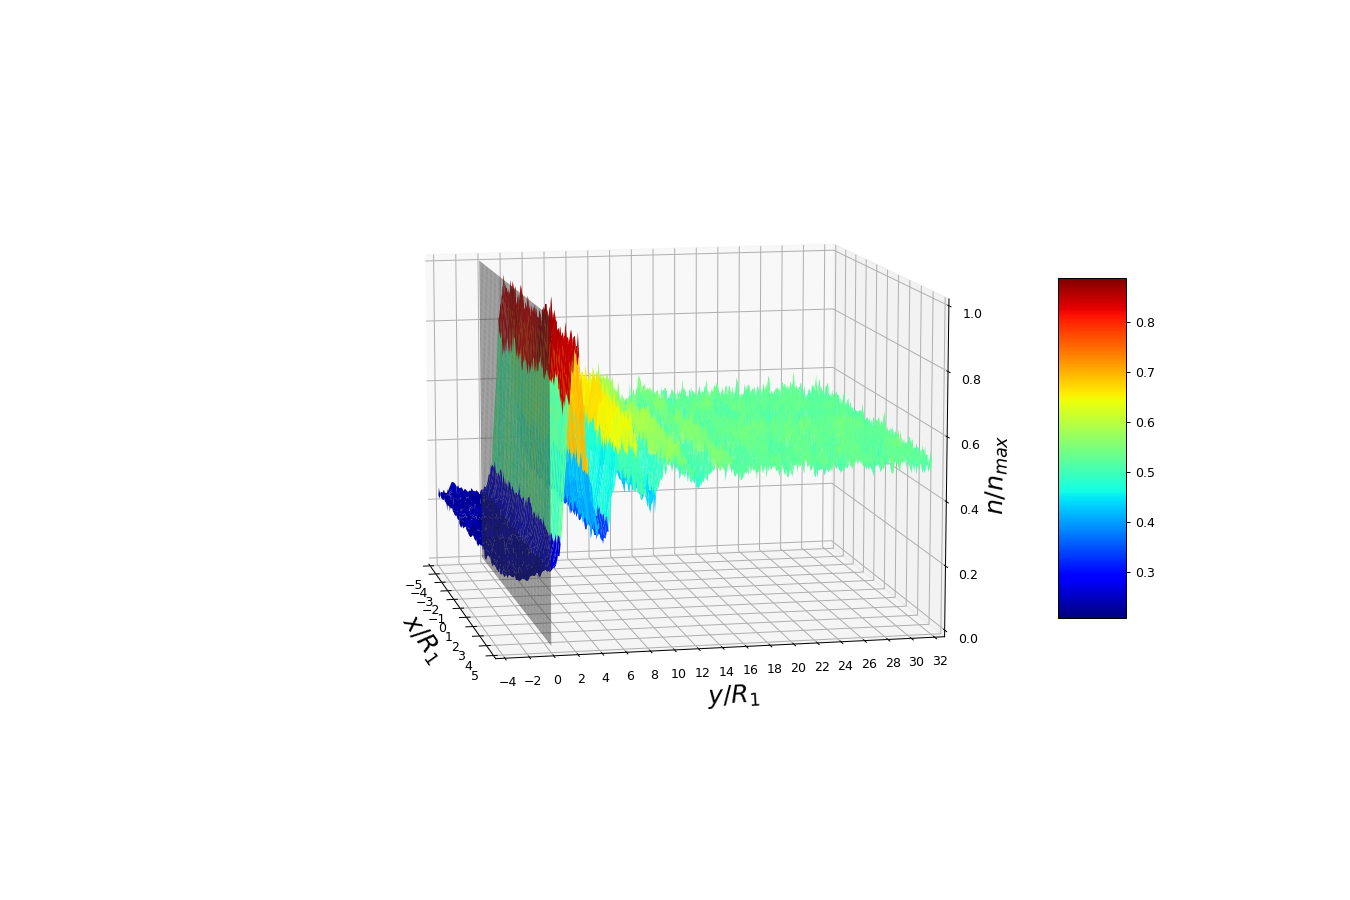

In [25]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(15,10))

# Make data.

X = np.arange(-5+dx/2,5,dx)
Y = np.arange(-4+dy/2,32.,dy)

X, Y = np.meshgrid(X, Y)

Z = cc_n.T   #Usando transposta


# Plot the surface.
surf = ax.plot_surface(X, Y, Z , cmap='jet')

z_p, x_p = np.meshgrid(np.linspace(0,1,100),np.linspace(-5,5, 100))

y_p = x_p*0

ax.plot_surface(x_p, y_p, z_p, color= "gray", alpha=0.5)  # the vertical plane

ax.set_xlabel(r'$x/R_1$',size=20)
ax.set_ylabel(r'$y/R_1$',size=20, labelpad=10)
ax.set_zlabel(r'$n/n_{max}$',size=20)

ax.set_xlim([-4.9,5.1])
ax.set_ylim([-3.9,32.1])

ax.set_xticks(np.arange(-5,5.1,1))
ax.set_yticks(np.arange(-4,32.1,2))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.view_init(10, -12)

#plt.savefig(path_in+'boris2D\\Extensao\\Densidade númerica_50000_particles_01.png',dpi=300, bbox_inches='tight',facecolor='w', edgecolor='w')

plt.show()

### Estimativa dos erros

In [18]:
Z = w_i.T*cc.T/(dx*R1*dy*R1)   #Usando transposta

n_massa = pd.DataFrame(Z,  columns=np.arange(x_1+dx/2,x_2,dx) , index = np.arange(y_1+dy/2,y_2,dy))
n_mass  = n_massa.T

n_mass = n_mass/1e6

In [19]:
n_mass

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,31.05,31.15,31.25,31.35,31.45,31.55,31.65,31.75,31.85,31.95
-4.95,8.037723,8.212564,8.201260,8.157108,8.154257,8.110837,8.126483,8.048531,8.077906,8.129087,...,20.227604,18.156441,18.419160,19.518609,19.126527,18.058614,19.980683,19.332746,18.764907,20.248148
-4.85,8.003061,8.167135,8.164657,8.162304,8.197079,8.196146,8.218463,8.236893,8.287322,8.256260,...,19.308359,19.254080,20.499391,20.378148,19.701626,18.788362,19.548459,19.253240,19.769674,20.171127
-4.75,8.235828,8.314017,8.130818,8.134263,8.068720,8.124465,8.108107,8.053414,8.018958,8.075353,...,16.560882,18.879388,19.242626,18.703200,19.336719,19.337688,18.397560,19.412131,19.294216,18.597365
-4.65,8.032996,8.170822,8.234920,8.217521,8.206605,8.192699,8.199489,8.252193,8.238923,8.245190,...,17.568612,18.554076,19.216577,19.783285,19.811991,19.096121,18.236457,19.464704,19.667911,19.692681
-4.55,8.137644,8.301210,8.165891,8.159941,8.235031,8.216258,8.257418,8.280075,8.247876,8.239657,...,18.951573,18.605248,17.692379,18.977538,18.804429,19.339877,18.274618,19.832286,20.733422,20.268858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,8.235733,8.376880,8.242640,8.239840,8.217158,8.252522,8.199855,8.200720,8.206457,8.223102,...,18.574146,19.747867,20.006846,17.909770,17.896620,17.883822,18.622788,19.856531,20.537250,17.942204
4.65,8.108641,8.309233,8.261025,8.222117,8.237790,8.202335,8.220388,8.202393,8.195128,8.156635,...,19.560156,18.204515,18.985860,18.709736,18.315766,18.496575,19.264324,19.011332,18.857613,17.467165
4.75,8.137809,8.234541,8.147599,8.146318,8.195124,8.183927,8.180888,8.210090,8.186011,8.169443,...,18.789221,18.441997,18.741083,17.972009,17.703157,18.093291,18.319556,18.701366,18.522766,17.580984
4.85,8.014265,8.236447,8.135891,8.197638,8.189648,8.158246,8.187713,8.155977,8.168162,8.190930,...,18.357358,18.025743,18.335936,18.595283,17.895731,18.839413,18.461991,18.905972,18.567788,19.042744


In [20]:
n_mass[n_mass.columns[0:40]]

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,-0.95,-0.85,-0.75,-0.65,-0.55,-0.45,-0.35,-0.25,-0.15,-0.05
-4.95,8.037723,8.212564,8.201260,8.157108,8.154257,8.110837,8.126483,8.048531,8.077906,8.129087,...,8.129435,8.158842,8.179092,8.153540,8.169159,8.144447,8.126348,8.098861,8.136032,8.132164
-4.85,8.003061,8.167135,8.164657,8.162304,8.197079,8.196146,8.218463,8.236893,8.287322,8.256260,...,8.190566,8.116270,8.109370,8.247770,8.169370,8.233239,8.219233,8.182418,8.186476,8.184148
-4.75,8.235828,8.314017,8.130818,8.134263,8.068720,8.124465,8.108107,8.053414,8.018958,8.075353,...,8.128689,8.157279,8.171549,8.199071,8.197109,8.208506,8.173832,8.120451,8.186076,8.155246
-4.65,8.032996,8.170822,8.234920,8.217521,8.206605,8.192699,8.199489,8.252193,8.238923,8.245190,...,8.142654,8.225609,8.168855,8.154978,8.063016,8.147240,8.075606,8.042133,8.012151,8.050916
-4.55,8.137644,8.301210,8.165891,8.159941,8.235031,8.216258,8.257418,8.280075,8.247876,8.239657,...,8.144057,8.039567,8.048116,8.022018,8.098523,8.132163,8.004464,8.085181,8.032110,8.084809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,8.235733,8.376880,8.242640,8.239840,8.217158,8.252522,8.199855,8.200720,8.206457,8.223102,...,7.983289,7.996742,7.975420,7.998542,8.057363,7.952138,7.983254,8.024264,8.032353,8.076175
4.65,8.108641,8.309233,8.261025,8.222117,8.237790,8.202335,8.220388,8.202393,8.195128,8.156635,...,7.972231,7.963514,7.942116,7.912827,7.958421,8.011801,7.974476,8.025423,7.994936,7.974439
4.75,8.137809,8.234541,8.147599,8.146318,8.195124,8.183927,8.180888,8.210090,8.186011,8.169443,...,8.061476,8.005590,8.062766,8.105207,8.081367,8.033006,8.043500,8.053858,8.001761,8.083053
4.85,8.014265,8.236447,8.135891,8.197638,8.189648,8.158246,8.187713,8.155977,8.168162,8.190930,...,8.118948,8.088375,8.126004,8.096833,8.110916,8.094777,8.088233,8.075953,8.099064,8.147117


In [27]:
#Número de partículas na região pré e pós choque.

np.sum(cc[0:40]), np.sum(cc[40:])

(31965805.0, 48119975.0)

In [26]:
d_up = np.mean(np.mean(n_mass[n_mass.columns[0:40]]))
d_dw = np.mean(np.mean(n_mass[n_mass.columns[40:]]))

d_up, d_dw

(8.139048478574841, 18.90753713662374)

In [33]:
nsig_up = n_mass[n_mass.columns[0:40]]*0.0112   # 0.0112 é o erro percentual estimado para cada bin na região pré-choque
nsig_dw = n_mass[n_mass.columns[40:]] *0.0258   # 0.0258 é o erro percentual estimado para cada bin na região pós-choque

In [34]:
err_up = np.sum(np.sum(np.abs(nsig_up)))/4000   # Propagação do erro pré-choque para o calculo de uma média
err_dw = np.sum(np.sum(np.abs(nsig_dw)))/32000  # Propagação do erro pós-choque

err_up, err_dw

(0.09115734296003822, 0.4878144581248927)

In [35]:
display(Markdown(rf'$n_1: {d_up:5.4}  \pm {err_up:1.3} $'))

$n_1: 8.139  \pm 0.0912 $

In [36]:
display(Markdown(rf'$n_2: {d_dw:6.5}  \pm {err_dw:1.3} $'))

$n_2: 18.908  \pm 0.488 $

#### Incerteza na densidade

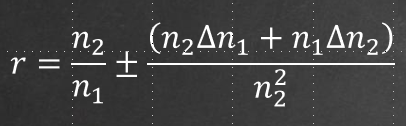

In [44]:
deln = (d_dw*err_up+d_up*err_dw)/(d_dw)**2
deln

0.01592723534171747

#### Incerteza na velocidade 

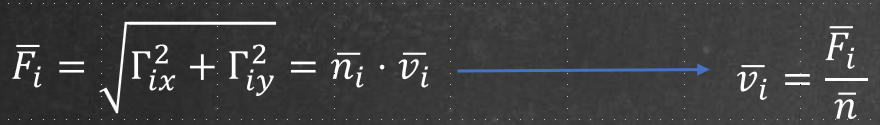

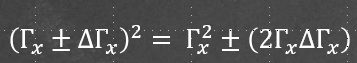

#### Cálculo dos fluxos médios

In [52]:
Fx_up = np.mean(np.mean(Fx[Fx.columns[0:40]]))
Fx_dw = np.mean(np.mean(Fx[Fx.columns[40:]]))

Fy_up = np.mean(np.mean(Fy[Fy.columns[0:40]]))
Fy_dw = np.mean(np.mean(Fy[Fy.columns[40:]]))

Fx_up, Fx_dw, Fy_up, Fy_dw

(-0.5822945891243921,
 0.2367448489389142,
 39.93161528980043,
 39.835953691537235)

#### Estimativa das incerteza dos fluxos médios 

In [54]:
nfx_up = Fx[Fx.columns[0:40]]*0.0112
nfx_dw = Fx[Fx.columns[40:]] *0.0258

nfy_up = Fy[Fy.columns[0:40]]*0.0112
nfy_dw = Fy[Fy.columns[40:]] *0.0258

In [55]:
errfx_up = np.sum(np.sum(np.abs(nfx_up)))/4000
errfx_dw = np.sum(np.sum(np.abs(nfx_dw)))/32000

errfy_up = np.sum(np.sum(np.abs(nfy_up)))/4000
errfy_dw = np.sum(np.sum(np.abs(nfy_dw)))/32000

errfx_up, errfx_dw, errfy_up, errfy_dw

(0.006904346554805029,
 0.05455718488269922,
 0.4472340912457649,
 1.0277676052416609)

#### Região pré-choque 

In [84]:
f_upx = Fx_up**2  
f_upy = Fy_up**2

delf_upx =  np.abs(2*Fx_up*errfx_up)
delf_upy =  np.abs(2*Fy_up*errfy_up)

#f_upx,f_upy, delf_upx, delf_upy

f_up    = (f_upx + f_upy)
delf_up = (delf_upx + delf_upy)

F_up    = np.sqrt(f_up)
Delf_up = 0.5*(1/(np.sqrt(f_up)))*delf_up

round(F_up,3), round(Delf_up,3)      # Fluxo médio na região pré-choque mais a incerteza

(39.936, 0.447)

####  Região pós-choque

In [85]:
f_dwx = Fx_dw**2  
f_dwy = Fy_dw**2

delf_dwx =  np.abs(2*Fx_dw*errfx_dw)
delf_dwy =  np.abs(2*Fy_dw*errfy_dw)

#f_upx,f_upy, delf_upx, delf_upy

f_dw    = (f_dwx + f_dwy)
delf_dw = (delf_dwx + delf_dwy)

F_dw    = np.sqrt(f_dw)
Delf_dw = 0.5*(1/(np.sqrt(f_dw)))*delf_dw

round(F_dw,3), round(Delf_dw,3)      # Fluxo médio na região pré-choque mais a incerteza

(39.837, 1.028)

#### Incerteza nas velocidades

In [86]:
v_up    = F_up/d_up
v_dw    = F_dw/d_dw

Del_vup = (F_up*err_up+d_up*Delf_up)/d_up**2
Del_vdw = (F_dw*err_dw+d_dw*Delf_dw)/d_dw**2

round(v_up*1e5,3), round(Del_vup*1e5,3), round(v_dw*1e5,3), round(Del_vdw*1e5,3)

(490669.895, 10991.074, 210691.942, 10873.227)

#### Estimativa do r a partir das velocidades

In [87]:
r_v    = v_up/v_dw
del_rv = (v_up*Del_vdw + v_dw*Del_vup)/v_dw**2

round(r_v, 3), round(del_rv, 3)

(2.329, 0.172)

In [88]:
v_up

4.9066989544237485

In [92]:
round(v_up*1e2,3)

490.67

<IPython.core.display.Javascript object>


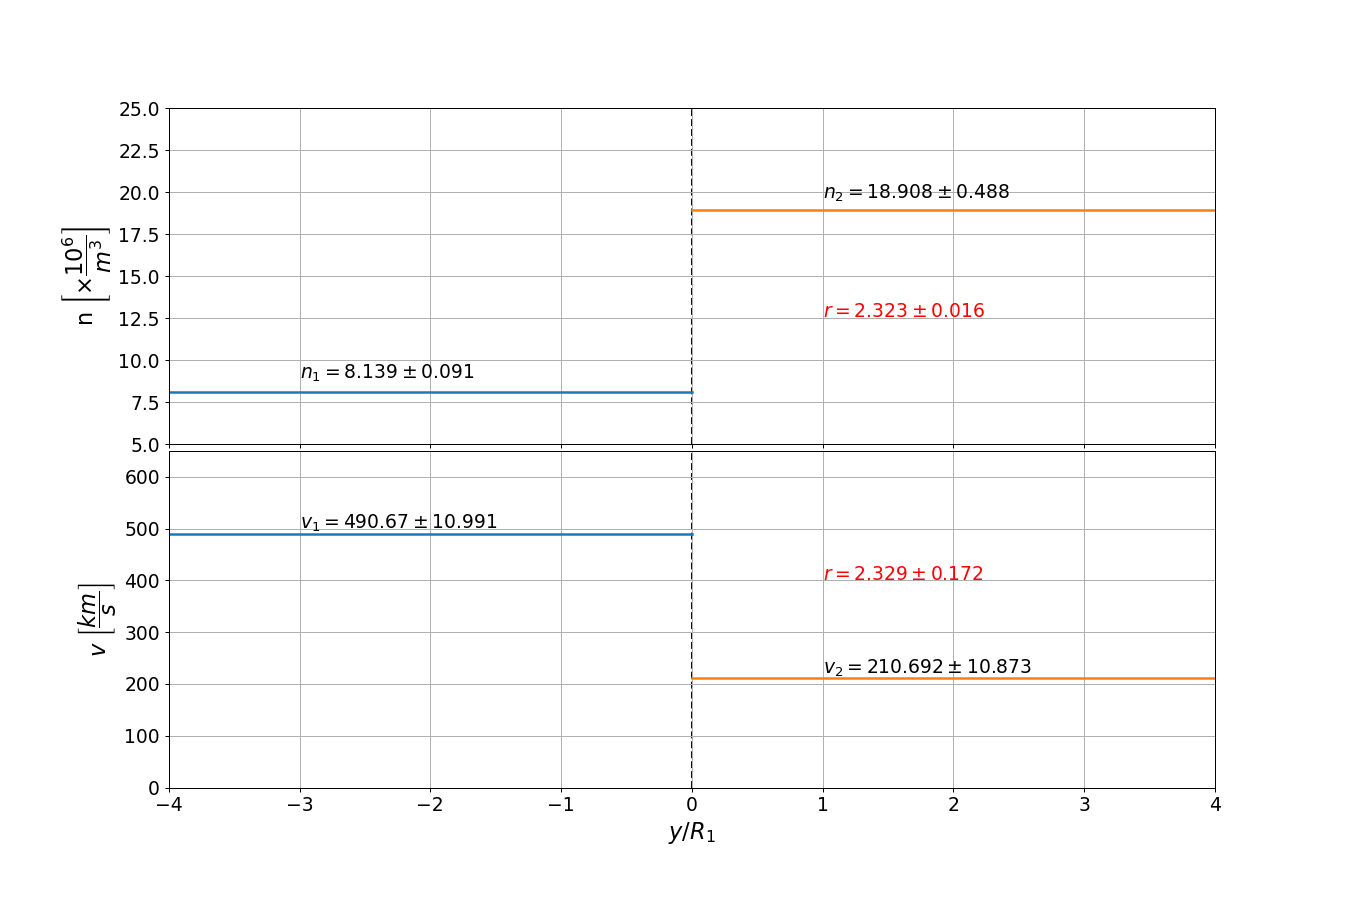

In [94]:
fig,ax = plt.subplots(2,gridspec_kw={'hspace': 0.02},figsize=(15,10))

n_1 = np.linspace(d_up, d_up, 50)
n_2 = np.linspace(d_dw, d_dw, 50)

v_1 = np.linspace(v_up*1e2, v_up*1e2, 50)
v_2 = np.linspace(v_dw*1e2, v_dw*1e2, 50)

xx_1 = np.linspace(-4,0, 50)
xx_2 = np.linspace(0,4, 50)

#Gráfico de densidade

ax[0].annotate(f'$n_1 = {round(d_up,3)} \pm {round(err_up,3)}$',    xy= (-3,8.9), size=15)  
ax[0].annotate(f'$n_2 = {round(d_dw,3)} \pm {round(err_dw,3)}$',    xy= (1,19.6), size=15)  
ax[0].annotate(f'$r   = {np.round(d_dw/d_up,3)} \pm {round(deln,3)}$',    xy= (1,12.6), size=15, color='red') 

ax[0].set_ylabel(r'n $\left[\times \dfrac{10^6}{m^3} \right]$', size=18)
ax[0].plot(xx_1, n_1, lw=2)
ax[0].plot(xx_2, n_2, lw=2)
ax[0].axvline(0, ls = '--', c = 'k', zorder=1)
ax[0].grid(axis='both')
ax[0].set_ylim([5,25])
ax[0].set_xlim([-4,4])
ax[0].set_xticks(np.arange(-4,4.1))

ax[0].tick_params(axis='both',labelsize=15)    
ax[0].label_outer()
#ax[0].set_aspect(1)

#Gráfico da velocidade

ax[1].annotate(f'$v_1 = {round(v_up*1e2,3)} \pm {round(Del_vup*1e2,3)}$',    xy= (-3,v_up*1e2+10), size=15)  
ax[1].annotate(f'$v_2 = {round(v_dw*1e2,3)} \pm {round(Del_vdw*1e2,3)}$',    xy= (1,v_dw*1e2+10), size=15)  
ax[1].annotate(f'$r   = {np.round(v_up/v_dw,3)} \pm {round(del_rv,3)}$',    xy= (1,400), size=15, color='red') 


ax[1].set_ylabel(r'$v$ '+ r'$ \left[\dfrac{km}{s} \right]$', size=18)
ax[1].set_xlabel(r'$y/R_1$', size=18)
ax[1].plot(xx_1, v_1, lw=2)
ax[1].plot(xx_2, v_2, lw=2)
ax[1].axvline(0, ls = '--', c = 'k', zorder=1)
ax[1].grid(axis='both')
ax[1].set_ylim([0,650]);
ax[1].set_xlim([-4,4])
ax[1].set_xticks(np.arange(-4,4.1))

ax[1].tick_params(axis='both',labelsize=15)  
#ax[1].set_aspect(1)

#plt.savefig(path_in+'boris2D\\Parametrosfisicos_50000_particles_01.png',dpi=300, bbox_inches='tight',facecolor='w', edgecolor='w')

plt.show()

### Cálculo da densidade média, em x/R1, ao longo de y/R1 

In [95]:
nerror_up = np.array(nsig_up.sum()/100)
nerror_dw = np.array(nsig_dw.sum()/100)

In [96]:
n_error = np.concatenate((nerror_dw,nerror_up)) # Juntos os dois vetores contendo os erros das medidas de densidade
#n_error

In [97]:
n_m = n_mass.describe().loc['mean']
n_M = np.array(n_m)
n_m

-3.95      8.114917
-3.85      8.267176
-3.75      8.179983
-3.65      8.184810
-3.55      8.184720
            ...    
 31.55    19.330670
 31.65    19.318271
 31.75    19.446583
 31.85    19.410351
 31.95    19.361532
Name: mean, Length: 360, dtype: float64

<IPython.core.display.Javascript object>


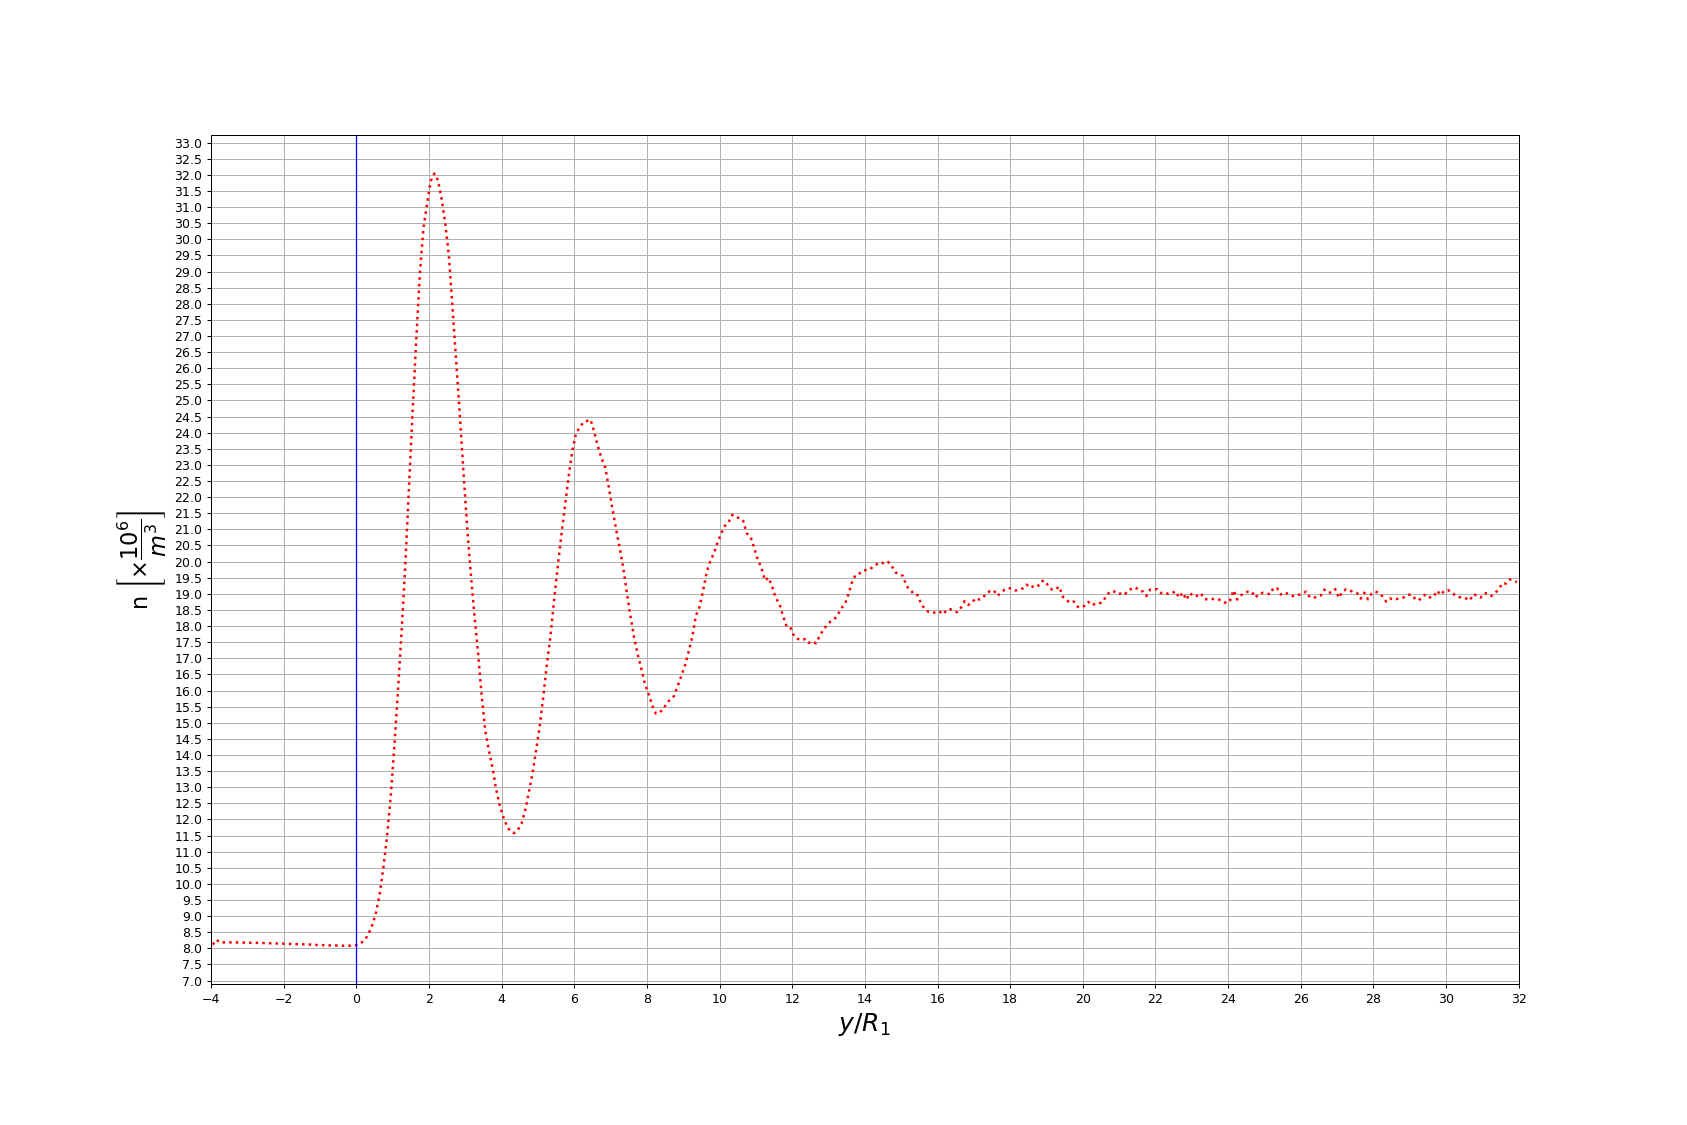

In [98]:
y_d = np.arange(y_1+dy/2,y_2,dy) 

fig,ax = plt.subplots(gridspec_kw={'hspace': 0.02},figsize=(15,10))

ax.plot(y_d, n_M, lw=2, ls=':', color='r')
ax.axvline(0 , color='b',lw=1)
#ax.scatter(y_d[78],n_M[78], lw=10, s=1)

ax.set_xlim([-4,32])
ax.set_xticks(np.arange(-4,32.1,2))
ax.set_yticks(np.arange(7,33.1,0.5))

ax.set_xlabel(r'$y/R_1$',size= 20)
ax.set_ylabel(r'n $\left[\times \dfrac{10^6}{m^3} \right]$', size=18, color='black')


ax.grid()